In [8]:
%matplotlib inline

import os
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [9]:
# Load simulation data with full morphologies
base_dir_plot = '/Users/susannedahle/CellTypeDependenceElStim/white_noise_10_nov'

# Imem plot data for selected frequencies
imem_plot_file_paths = [
    os.path.join(base_dir_plot, f'plot_imem_{i}.npy')
    for i in range(8)
]

In [10]:
# Load simulation data with Fourier analysis
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/white_noise_25_nov'

file_paths = [
    os.path.join(base_dir,f"cdm_data_neocortical_{i}.npy") 
    for i in range(8)
]

imem_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in file_paths
]

imem_data = {}
for data in imem_data_list:
    imem_data.update(data)

# Four example cells
get_idx_list = list(imem_data.keys())
selected_cells = ['L4_BP_bIR215_5', "L5_TTPC2_cADpyr232_3", "L5_MC_bAC217_1", 'L4_SS_cADpyr230_1', "L5_NGC_bNAC219_5"]
positions = {item: get_idx_list.index(item) for item in selected_cells if item in get_idx_list}

items_list = list(imem_data.items())
selected_items = [items_list[positions[cell]] for cell in selected_cells]

subset_imem_data = dict(selected_items)

In [11]:
# Can only load some selected cells at a time for plotting
def load_plot_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [12]:
cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)",
    'L4_SS_cADpyr230_1': 'L4 Spiny Stellate cell (SS)'
}

short_cell_names = {
    'L4_BP_bIR215_5': 'L4 BP',
    "L5_MC_bAC217_1": "L5 MC",
    "L5_TTPC2_cADpyr232_3": "L5 TTPC",
    "L5_NGC_bNAC219_5": "L5 NGC",
    'L4_SS_cADpyr230_1': 'L4 SS'
}

cell_vmem_colors = {
    'L4_BP_bIR215_5': "tab:grey",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown',
    'L4_SS_cADpyr230_1': 'tab:pink'
}

cell_cdm_colors = {
    'L4_BP_bIR215_5': "tab:orange",
    "L5_MC_bAC217_1": "tab:blue",
    "L5_TTPC2_cADpyr232_3": "tab:green",
    "L5_NGC_bNAC219_5": 'tab:red',
    'L4_SS_cADpyr230_1': 'tab:purple'
}

cell_cdm_up_down_colors = {
    'L4_BP_bIR215_5':  "#A95400",  # darker/desaturated orange
    "L5_TTPC2_cADpyr232_3": "#1A5A1D",  # darker/desaturated green
    'L4_SS_cADpyr230_1': "#51306A",  # darker/desaturated purple
    "L5_MC_bAC217_1":   "#004466",  # dark blue variant
    "L5_NGC_bNAC219_5": "coral",  # darker vermillion (still not orange)
}


In [15]:
def plot_imem_figure_neo(imem_plot_file_paths, avg_imem_data_dict, 
                         selected_cells=None, xlim1=(0, 0.0003), xlim2=(0.0018, None)):

    # --- Load your Imem amplitude & phase data ---
    imem_amp_dict = load_plot_data_from_files(imem_plot_file_paths, selected_cells)
    if selected_cells:
        unique_cells = [cell for cell in selected_cells if cell in imem_amp_dict]
    num_cells = len(unique_cells)
    assert num_cells == 5, "This layout assumes exactly 5 cells (5 rows)."

    # --- Figure layout ---
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(5, 2, width_ratios=[2.5, 1.5],
                           height_ratios=[1, 1, 1, 1, 1],
                           wspace=0.2, hspace=0.4)

    freq_colors = ['tab:purple', 'tab:orange', 'tab:green']

    # ================================================
    # LEFT COLUMN: scatter of instantaneous Imem(t_max)
    # ================================================
    for i, label in enumerate(unique_cells):

        cell_data = imem_amp_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])

        imem_amps = np.array(cell_data['imem_amps'])      # shape: (seg, freq)
        imem_phases = np.array(cell_data['imem_phases'])   # shape: (seg, freq)

        amp_data = avg_imem_data_dict[label]
        amp_freqs = np.array(amp_data['frequency'])
        input_current_phases = amp_data['input_current_phase'] 
        cdm_amps = np.array(amp_data['cdm'])  
        cdm_phases = np.array(amp_data['cdm_phase'])  
        z_coords = z.mean(axis=-1)

        # Compute t_max for each frequency
        t_max_dict = {}

        # Find direction of pz at ~ 1 Hz
        input_current_phase_0 = input_current_phases[0]
        t_max_inp_0 = (3*np.pi/2 - input_current_phase_0) / (2*np.pi* amp_freqs[0])
        cdm_amp_0 = cdm_amps[0]
        cdm_phase_0 = cdm_phases[0]
        cdm_value_0 = cdm_amp_0 * np.sin(2*np.pi* amp_freqs[0] *t_max_inp_0 + cdm_phase_0)
        if cdm_value_0 < 0:
            t_max_cdm_sign = 3
        else:
            t_max_cdm_sign = 1
        # Find the time of maximum pz
        for f in freqs:
            # Find pz above and below at t max
            f_idx = np.argmin(np.abs(amp_freqs - f))
            cdm_amp = cdm_amps[f_idx]
            cdm_phase = cdm_phases[f_idx]
            
            t_max_cdm = (t_max_cdm_sign * np.pi/2 - cdm_phase)/(2*np.pi*f)

            while t_max_cdm < 0:
                t_max_cdm += 1.0 / f

            t_max_dict[f] = t_max_cdm

        # ---- Sub-panels: morphology + two-axis scatter ----
        left_ratio = 1.9
        middle_ratio = 0.6
        right_ratio = 1.2

        inner_gs = gridspec.GridSpecFromSubplotSpec(
            1, 3, subplot_spec=gs[i, 0],
            width_ratios=[left_ratio, middle_ratio, right_ratio], wspace=0.2
        )

        ax_morph = fig.add_subplot(inner_gs[0])
        ax_left = fig.add_subplot(inner_gs[1])
        ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)

        # --- Morphology ---
        for idx in range(totnsegs):
            ax_morph.plot(x[idx], z[idx], c=cell_vmem_colors[label], lw=1)

        ax_morph.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0],
                      'o', color='black', markersize=2)

        ax_morph.set_title(f'{cell_names[label]}', fontsize=10)
        ax_morph.set_xticks([])
        ax_morph.set_frame_on(False)
        ax_morph.set_aspect('equal')

        if label == 'L4_BP_bIR215_5':
            ax_morph.set_xlim(np.min(x.mean(axis=-1))-150, np.max(x.mean(axis=-1))+150)
        elif label in ["L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3"]:
            ax_morph.set_xlim(np.min(x.mean(axis=-1))-50, np.max(x.mean(axis=-1))+50)

        # --- Scatter instantaneous Imem(t_max) ---
        for f_idx, f in enumerate(freqs):

            chosen_t = t_max_dict[f]
            z_imem_map = defaultdict(float)

            # -------- compute full-tree values (unchanged) -------------
            for seg_idx in range(totnsegs):
                amp = imem_amps[seg_idx][f_idx]
                phase = imem_phases[seg_idx][f_idx]

                imem_t = amp * np.sin(2*np.pi*f*chosen_t + phase)
                z_imem_map[z_coords[seg_idx]] += imem_t

            z_vals = list(z_imem_map.keys())
            imem_vals = list(z_imem_map.values())

            # Marker styling unchanged
            if f == 10:
                marker, size, alpha = 'o', 20, 0.8
            elif f == 100:
                marker, size, alpha = 'x', 10, 0.8
            else:
                marker, size, alpha = '^', 6, 0.5

            # ============================================================
            # SOMA-ONLY PLOT FOR ax_left
            # ============================================================
            soma_amp = imem_amps[0][f_idx]
            soma_phase = imem_phases[0][f_idx]
            soma_imem_t = soma_amp * np.sin(2*np.pi*f*chosen_t + soma_phase)
            soma_z = z_coords[0]

            ax_left.scatter(
                soma_imem_t, soma_z,
                label=f'{f} Hz', alpha=alpha, marker=marker,
                color=freq_colors[f_idx], s=size
            )

            # ---------------- full-branch scatter for ax_right ------------
            ax_right.scatter(
                imem_vals, z_vals,
                label=f'{f} Hz', alpha=alpha, marker=marker,
                color=freq_colors[f_idx], s=size
            )

        # --- Axis settings ---
        ax_left.axvline(0, color='black', linestyle=':')
        ax_right.axvline(0, color='black', linestyle=':')

        ax_left.set_xlim(xlim1)

        # x-lim for right scatter 
        if label == 'L4_SS_cADpyr230_1':
            right_lim =(-1.3e-4, 0.8e-4)
        else:
            right_lim = xlim2
        ax_right.set_xlim(right_lim)

        # Hide ticks/spines
        ax_right.yaxis.set_visible(False)
        ax_right.spines['left'].set_visible(False)
        ax_left.spines['right'].set_visible(False)

        # Add diagonal breaks
        d = 0.015
        kwargs = dict(transform=ax_left.transAxes, color='k', clip_on=False)
        ax_left.plot([1-d*middle_ratio/left_ratio, 1+d*middle_ratio/left_ratio], [-d, +d], **kwargs)
        ax_left.plot([1-d*middle_ratio/left_ratio, 1+d*middle_ratio/left_ratio], [1-d, 1+d], **kwargs)

        kwargs.update(transform=ax_right.transAxes)
        ax_right.plot([-d*middle_ratio/right_ratio, +d*middle_ratio/right_ratio], [-d, +d], **kwargs)
        ax_right.plot([-d*middle_ratio/right_ratio, +d*middle_ratio/right_ratio], [1-d, 1+d], **kwargs)

        # x-ticks on scatterplot
        fmt_left = ScalarFormatter(useMathText=True)
        fmt_left.set_powerlimits((-2, 2))
        ax_left.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
        ax_left.xaxis.set_major_formatter(fmt_left)
        ax_left.tick_params(axis='x', labelsize=7)

        fmt_right = ScalarFormatter(useMathText=True)
        fmt_right.set_powerlimits((-2, 2))
        ax_right.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
        ax_right.xaxis.set_major_formatter(fmt_right)
        ax_right.tick_params(axis='x', labelsize=7)

        if i == 1:
            ax_right.legend(loc='upper right', fontsize=8)
        if i == 2:
            ax_left.yaxis.set_major_locator(MultipleLocator(250))

        ax_left.set_ylabel('z [µm]', fontsize=10)

    fig.text(0.47, 0.07, 'Sum of $I_m(t = t_{max})$ [nA]', ha='center', fontsize=10)

    # =======================================================
    # RIGHT COLUMN: λ_AC and p_z frequency plots 
    # =======================================================

    for i, cell_name in enumerate(unique_cells):

        ax_right_cell = fig.add_subplot(gs[i, 1])

        cell_info = avg_imem_data_dict[cell_name]
        frequency = cell_info['frequency']
        avg_pos_above = cell_info['avg_return_pos_above_soma']
        avg_pos_below = cell_info['avg_return_pos_below_soma']
        cdm_amps = cell_info['cdm']
        cdm_phases = cell_info['cdm_phase']
        cdm_pos_amps = cell_info['cdm_pos']
        cdm_neg_amps = cell_info['cdm_neg']
        cdm_pos_phases = cell_info['cdm_phase_pos']
        cdm_neg_phases = cell_info['cdm_phase_neg']
        input_current_phases = cell_info['input_current_phase']

        ax_right_cell.axhline(0, color = 'dimgray', linestyle = (0, (6,1)), linewidth=0.8)

        # ======== First axis: λ_AC ========
        ax_right_cell.semilogx(
            frequency[:-1], avg_pos_above[:-1],
            label='$\lambda_{AC}$ Above',
            color=cell_vmem_colors[cell_name], linestyle=':'
        )
        ax_right_cell.semilogx(
            frequency[:-1], avg_pos_below[:-1],
            label='$\lambda_{AC}$ Below',
            color=cell_vmem_colors[cell_name], linestyle='--'
        )

        ax_right_cell.set_title(f'{short_cell_names[cell_name]}', fontsize=10)
        ax_right_cell.set_xlim(1, 2000)
        lam_ylim = 1.2*max(np.max(avg_pos_above), np.max(np.abs(avg_pos_below)))
        ax_right_cell.set_ylim(-lam_ylim, lam_ylim)
        ax_right_cell.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
        ax_right_cell.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.8)
        ax_right_cell.set_ylabel('$\lambda_{AC}$ [µm]', fontsize=11, color=cell_vmem_colors[cell_name])
        ax_right_cell.tick_params(axis='y', labelcolor=cell_vmem_colors[cell_name])
        
        # ======== Second axis: CDM p_z ========
        ax2 = ax_right_cell.twinx()

        cdm_max_values = []
        cdm_values_pos = []
        cdm_values_neg = []
        for f_idx, f in enumerate(frequency):
            input_phase = input_current_phases[f_idx]
            t_max_inp = (3*np.pi/2 - input_phase)/(2*np.pi*f)

            cdm_amp = cdm_amps[f_idx]
            cdm_phase = cdm_phases[f_idx]
            cdm_value = cdm_amp * np.sin(2*np.pi*f*t_max_inp + cdm_phase)

            if f_idx == 0:
                if cdm_value < 0:
                    t_max_cdm_sign = 3
                else:
                    t_max_cdm_sign = 1
            
            t_max_cdm = (t_max_cdm_sign * np.pi/2 - cdm_phase)/(2*np.pi*f)

            cdm_max_value = cdm_amp * np.sin(2*np.pi*f*t_max_cdm + cdm_phase)
            cdm_max_values.append(cdm_max_value)

            cdm_pos_amp = cdm_pos_amps[f_idx]
            cdm_pos_phase = cdm_pos_phases[f_idx]
            cdm_value_pos = cdm_pos_amp * np.sin(2*np.pi*f*t_max_cdm + cdm_pos_phase)
            cdm_values_pos.append(cdm_value_pos)

            cdm_neg_amp = cdm_neg_amps[f_idx]
            cdm_neg_phase = cdm_neg_phases[f_idx]
            cdm_value_neg = cdm_neg_amp * np.sin(2*np.pi*f*t_max_cdm + cdm_neg_phase)
            cdm_values_neg.append(cdm_value_neg)
        
        ax2.semilogx(
            frequency[:-1], cdm_max_values[:-1],
            label='$p_z$ Tot',
            color=cell_cdm_colors[cell_name], linestyle='-'
        )

        ax2.semilogx(
            frequency[:-1], cdm_values_pos[:-1],
            label='$p_z$ Above',
            color=cell_cdm_up_down_colors[cell_name], linestyle=':'
        )
        ax2.semilogx(
            frequency[:-1], cdm_values_neg[:-1],
            label='$p_z$ Below',
            color=cell_cdm_up_down_colors[cell_name], linestyle='--'
        )

        ax2.set_xlim(1, 2000)
        cdm_ylim = 1.2*max(np.max(cdm_values_pos), np.max(np.abs(cdm_values_neg)))
        ax2.set_ylim(-cdm_ylim, cdm_ylim)
        ax2.set_ylabel('$p_z$ [nA·µm]', fontsize=11, color = cell_cdm_colors[cell_name])
        ax2.tick_params(axis='y', labelcolor=cell_cdm_colors[cell_name])

        # ======== Combined legend ========
        h1, l1 = ax_right_cell.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        
        if cell_name == 'L4_SS_cADpyr230_1':
            loc = 'center left'
        elif cell_name == 'L5_NGC_bNAC219_5':
            loc = 'center'
        elif cell_name == 'L5_TTPC2_cADpyr232_3':
            loc = 'lower right'
        else:
            loc = 'best'

        ax2.legend(h1 + h2, l1 + l2, fontsize=7, loc=loc,
                frameon=True, fancybox=True, framealpha=0.9, ncol =2)
    

    fig.text(0.78, 0.07, 'Frequency [Hz]', ha='center', fontsize=10)

    fig.text(0.14, 0.91, 'A', fontsize=12, fontweight='bold')
    fig.text(0.33, 0.91, 'B', fontsize=12, fontweight='bold')
    fig.text(0.62, 0.91, 'C', fontsize=12, fontweight='bold')

    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig7.pdf',
                bbox_inches='tight')
    plt.show()

<>:219: SyntaxWarning: invalid escape sequence '\l'
<>:224: SyntaxWarning: invalid escape sequence '\l'
<>:234: SyntaxWarning: invalid escape sequence '\l'
<>:219: SyntaxWarning: invalid escape sequence '\l'
<>:224: SyntaxWarning: invalid escape sequence '\l'
<>:234: SyntaxWarning: invalid escape sequence '\l'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_43625/2173712980.py:219: SyntaxWarning: invalid escape sequence '\l'
  label='$\lambda_{AC}$ Above',
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_43625/2173712980.py:224: SyntaxWarning: invalid escape sequence '\l'
  label='$\lambda_{AC}$ Below',
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_43625/2173712980.py:234: SyntaxWarning: invalid escape sequence '\l'
  ax_right_cell.set_ylabel('$\lambda_{AC}$ [µm]', fontsize=11, color=cell_vmem_colors[cell_name])


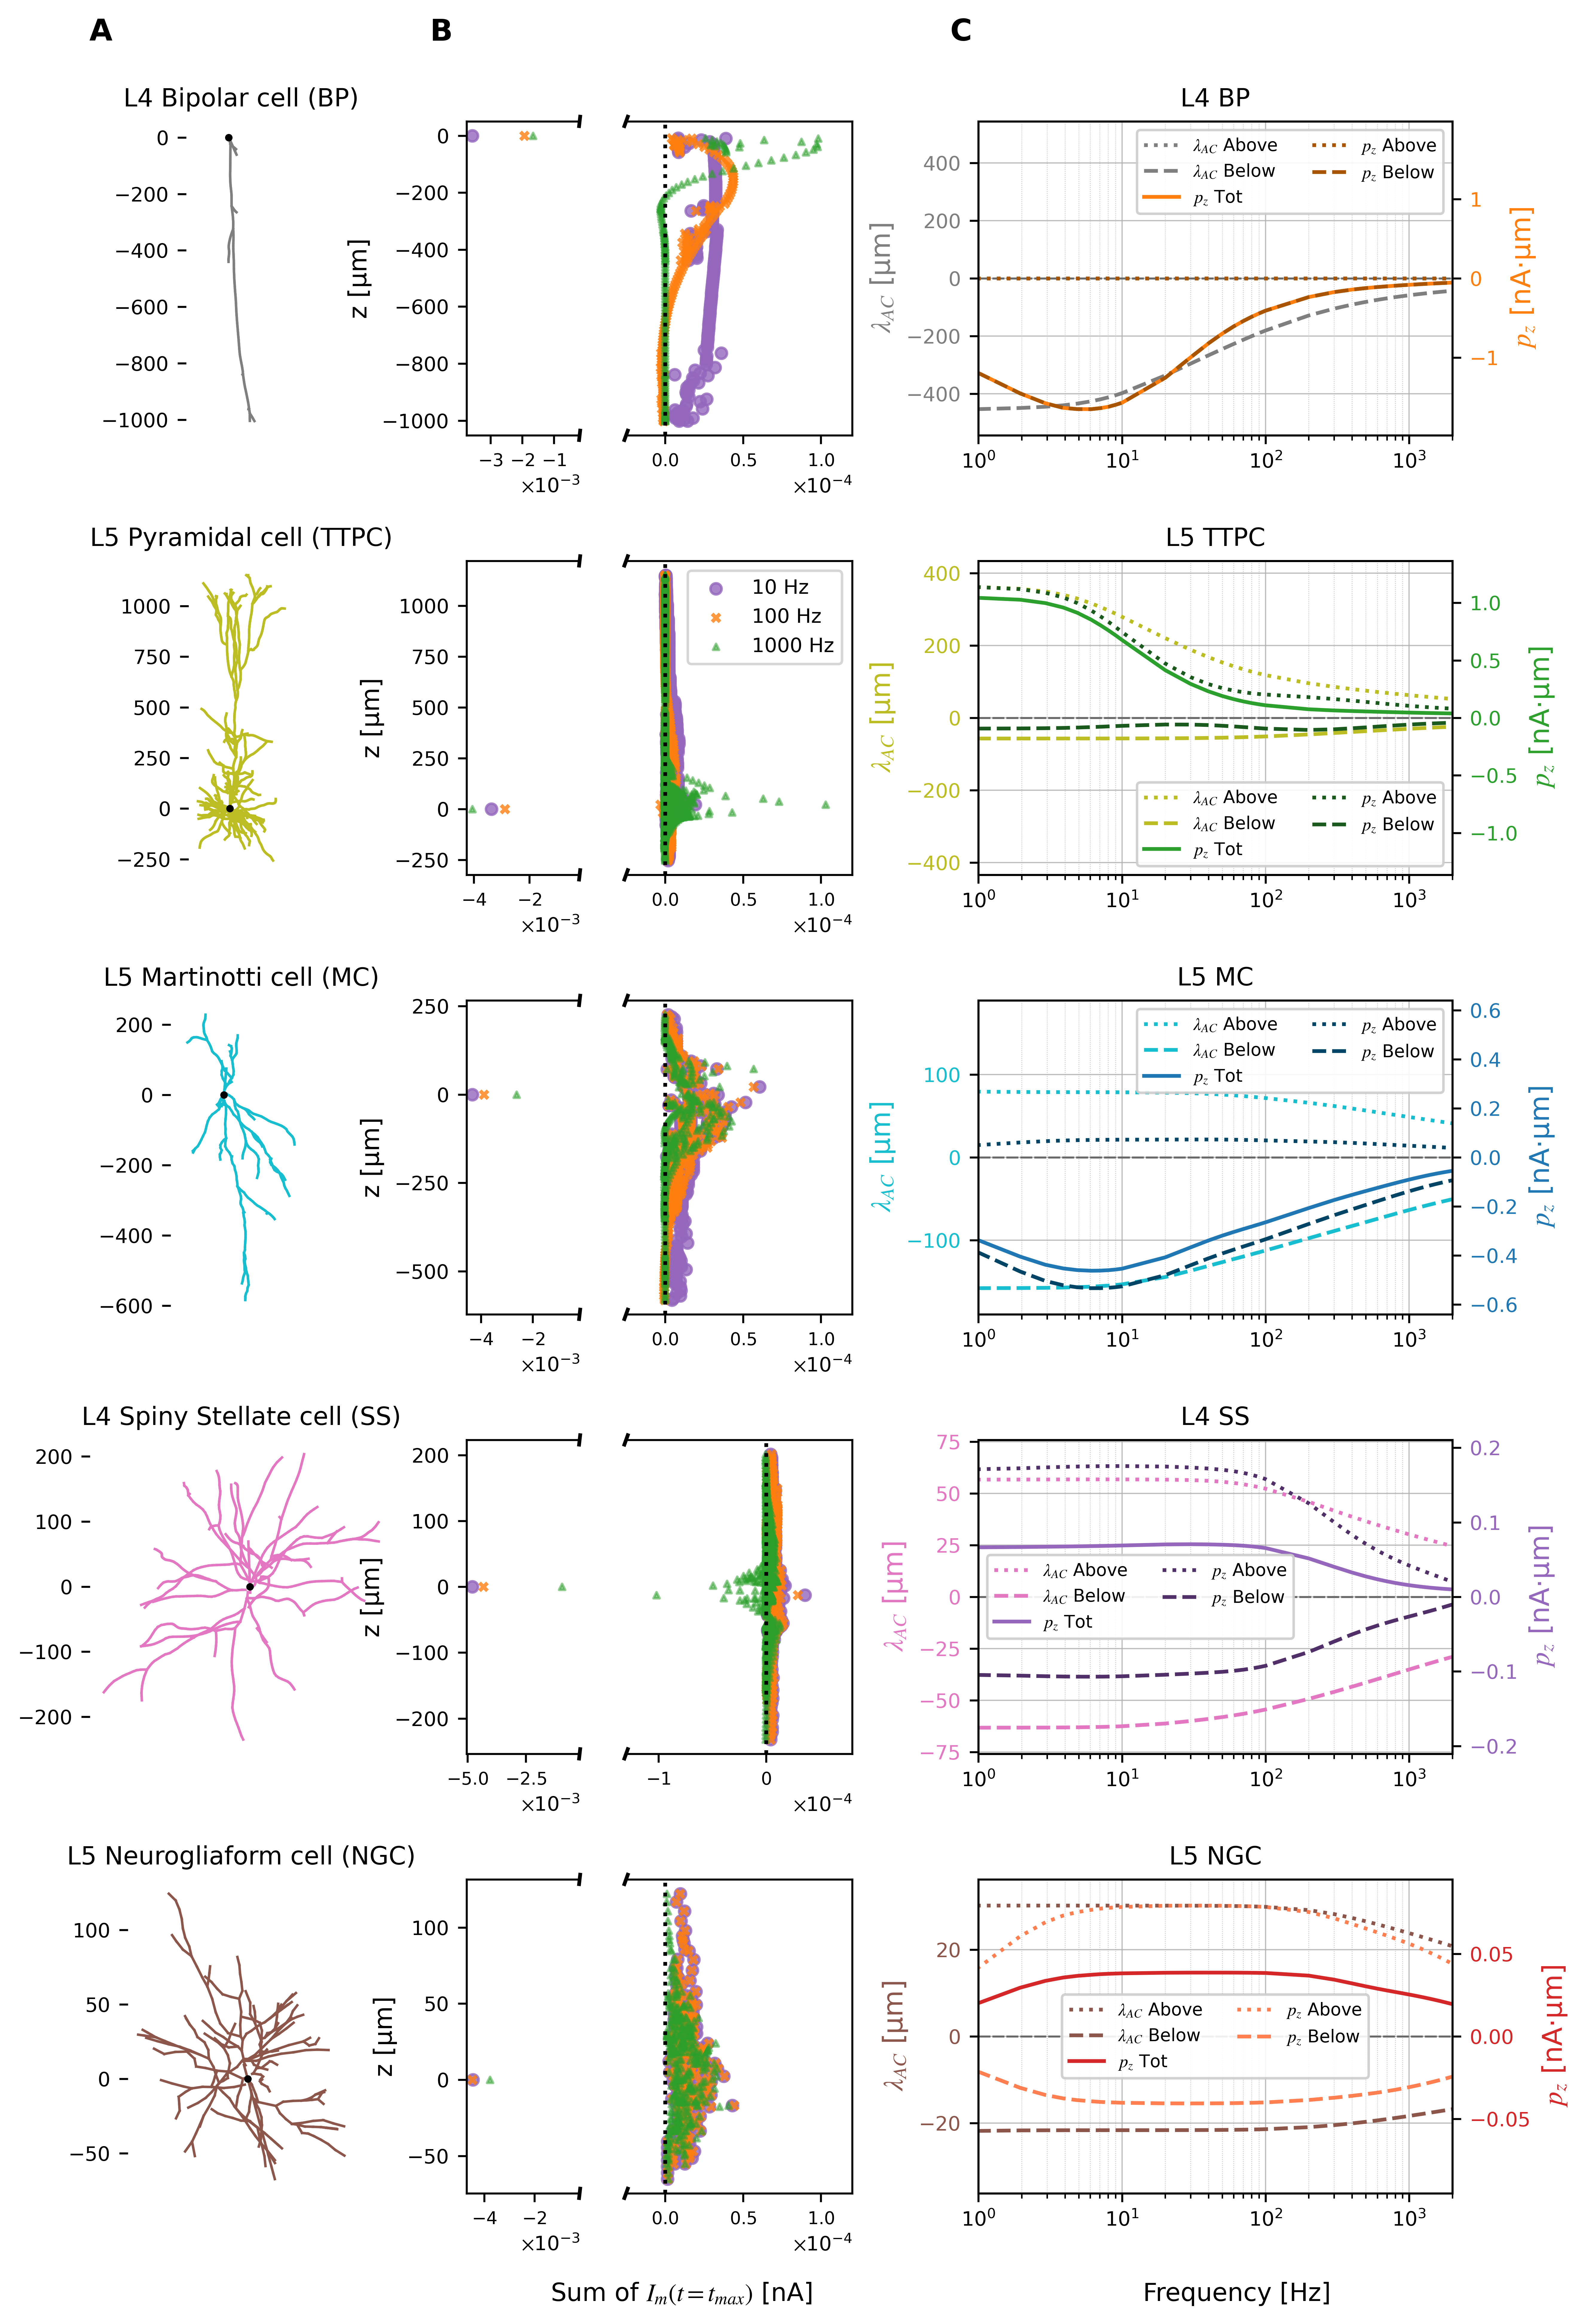

In [16]:
plot_imem_figure_neo(imem_plot_file_paths, subset_imem_data, selected_cells=selected_cells, xlim1=(None, -1.9e-4), xlim2=(-2.5e-5, 1.2e-4))